<a href="https://www.kaggle.com/code/fotimakhongulomova/task-2-policing-equity?scriptVersionId=142418761" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import date
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.feature_selection import VarianceThreshold


warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Constants

In [2]:
FILE = '/kaggle/input/data-science-for-good/Dept_11-00091/11-00091_Field-Interviews_2011-2015.csv'

## Load Data

In [3]:
data = pd.read_csv(FILE, low_memory=False)

df = pd.DataFrame(data)

df.drop([0], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,INCIDENT_UNIQUE_IDENTIFIER,INCIDENT_UNIQUE_IDENTIFIER.1,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,INCIDENT_TIME,SUBJECT_DETAILS,SUBJECT_RACE,...,VEHICLE_DETAILS.1,OFFICER_SUPERVISOR,OFFICER_ID,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_ETHNICITY,OFFICER_RACE,OFFICER_AGE,LOCATION_STREET_NUMBER,LOCATION_CITY
0,938283,621880,MALE,NORMANDY ST at SUPPLE RD,B2,3,12/10/13 0:00,12/10/13 0:00,YES,B(Black),...,MA,10132,98656,9999,OTHER,NaN,B(Black),59,3274,NO DATA ENTERED
1,881897,565177,MALE,75 BOYLSTON ST,A1,1,5/24/12 0:00,5/24/12 0:00,NO,W(White),...,NO DATA ENTERED,8949,9765,1,A1,NaN,W(White),26,543,OTHER
2,882060,565340,MALE,5 TOPLIFF ST,C11,5,6/4/12 0:00,6/4/12 0:00,YES,B(Black),...,NO DATA ENTERED,11312,83575,16,YVSF,NaN,B(Black),18,4493,NO DATA ENTERED
3,971623,653895,MALE,170 MORTON ST,B2,3,6/21/14 0:00,6/21/14 0:00,YES,B(Black),...,NO DATA ENTERED,9375,76146,25,BIKE,NaN,B(Black),24,3094,Dorchester
4,882761,566043,MALE,0 ST ALPHONSUS ST,B2,3,12/2/10 0:00,12/2/10 0:00,YES,B(Black),...,MA,NaN,107106,3,B2,NaN,B(Black),70,4241,Dorchester


# Step 1: Data Exploration and Preprocessing

In [4]:
print(f"\nThe shape of the data: {df.shape}\n")
print(f"The types of the data: \n{df.dtypes}\n")
print(f"The empty row in the data: \n{df.isnull().sum()}")


The shape of the data: (152230, 34)

The types of the data: 
INCIDENT_UNIQUE_IDENTIFIER                      object
INCIDENT_UNIQUE_IDENTIFIER.1                    object
SUBJECT_GENDER                                  object
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION    object
LOCATION_DISTRICT                               object
LOCATION_DISTRICT.1                             object
INCIDENT_DATE                                   object
INCIDENT_TIME                                   object
SUBJECT_DETAILS                                 object
SUBJECT_RACE                                    object
SUBJECT_DETAILS.1                               object
SUBJECT_DETAILS.2                               object
UNKNOWN_FIELD_TYPE                              object
UNKNOWN_FIELD_TYPE.1                            object
SEARCH_CONDUCTED                                object
SEARCH_REASON                                   object
INCIDENT_REASON                                 object
INC

### Data Cleaning

In [5]:
# data cleaning
df.drop(["INCIDENT_UNIQUE_IDENTIFIER", 'INCIDENT_UNIQUE_IDENTIFIER.1', "UNKNOWN_FIELD_TYPE.1", 
         "INCIDENT_TIME", 'LOCATION_STREET_NUMBER', 'OFFICER_ID', "LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION", 
         "UNKNOWN_FIELD_TYPE", 'OFFICER_ASSIGNMENT', 'OFFICER_ASSIGNMENT.1', 'OFFICER_SUPERVISOR', 'SUBJECT_DETAILS.1'], axis=1, inplace=True)

### Handling missing values in the dataframe

In [6]:
for feature in df.columns:
    if df[feature].isnull().sum() > 90000:
        df.drop([feature], axis=1, inplace=True)
        
for feature in df.columns:
    df[feature].replace(to_replace=["NO DATA ENTERED"], value="UNKNOWN", inplace=True)
    df[feature].replace(to_replace=np.nan, value="UNKNOWN", inplace=True) 

In [7]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
SUBJECT_GENDER         0
LOCATION_DISTRICT      0
LOCATION_DISTRICT.1    0
INCIDENT_DATE          0
SUBJECT_DETAILS        0
SUBJECT_RACE           0
SUBJECT_DETAILS.2      0
INCIDENT_REASON        0
INCIDENT_REASON.1      0
DISPOSITION            0
VEHICLE_MAKE           0
VEHICLE_YEAR           0
VEHICLE_COLOR          0
VEHICLE_DETAILS.1      0
OFFICER_RACE           0
OFFICER_AGE            0
LOCATION_CITY          0
dtype: int64


In [8]:
# Extracting dates

df['INCIDENT_DATE'] = pd.to_datetime(df.INCIDENT_DATE)
df["INCIDENT_YEAR"] = df["INCIDENT_DATE"].dt.year
df["INCIDENT_MONTH"] = df["INCIDENT_DATE"].dt.month
df["INCIDENT_WEEKDAY"] = df["INCIDENT_DATE"].dt.strftime('%w')
df['INCIDENT_DATE'] = df['INCIDENT_DATE'].astype(str)
df["INCIDENT_DATE"] = df.INCIDENT_DATE.str.split("-").map(lambda x: x[2])

In [9]:
df.head()

,SUBJECT_GENDER,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON,INCIDENT_REASON.1,DISPOSITION,VEHICLE_MAKE,VEHICLE_YEAR,VEHICLE_COLOR,VEHICLE_DETAILS.1,OFFICER_RACE,OFFICER_AGE,LOCATION_CITY,INCIDENT_YEAR,INCIDENT_MONTH,INCIDENT_WEEKDAY
0,MALE,B2,3,10,YES,B(Black),Med,INVESTIGATIVE,"DRUGS, INVESTIGATION",SFO,NISSAN,2012,SILVER,MA,B(Black),59,UNKNOWN,2013,12,2
1,MALE,A1,1,24,NO,W(White),Med,RADIO CALL,"DRUGS, POSSESSION",F,UNKNOWN,0,UNKNOWN,UNKNOWN,W(White),26,OTHER,2012,5,4
2,MALE,C11,5,04,YES,B(Black),Dark,OTHER (SPECIFY),"INVESTIGATE, PERSON",F,UNKNOWN,0,UNKNOWN,UNKNOWN,B(Black),18,UNKNOWN,2012,6,1
3,MALE,B2,3,21,YES,B(Black),Med,INVESTIGATIVE,ABDW,S,UNKNOWN,0,UNKNOWN,UNKNOWN,B(Black),24,Dorchester,2014,6,6
4,MALE,B2,3,02,YES,B(Black),Light,INVESTIGATIVE,VAL,F,SATURN,2001,RED,MA,B(Black),70,Dorchester,2010,12,4


In [10]:
df.shape

(152230, 20)

In [11]:
df.head()

,SUBJECT_GENDER,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON,INCIDENT_REASON.1,DISPOSITION,VEHICLE_MAKE,VEHICLE_YEAR,VEHICLE_COLOR,VEHICLE_DETAILS.1,OFFICER_RACE,OFFICER_AGE,LOCATION_CITY,INCIDENT_YEAR,INCIDENT_MONTH,INCIDENT_WEEKDAY
0,MALE,B2,3,10,YES,B(Black),Med,INVESTIGATIVE,"DRUGS, INVESTIGATION",SFO,NISSAN,2012,SILVER,MA,B(Black),59,UNKNOWN,2013,12,2
1,MALE,A1,1,24,NO,W(White),Med,RADIO CALL,"DRUGS, POSSESSION",F,UNKNOWN,0,UNKNOWN,UNKNOWN,W(White),26,OTHER,2012,5,4
2,MALE,C11,5,04,YES,B(Black),Dark,OTHER (SPECIFY),"INVESTIGATE, PERSON",F,UNKNOWN,0,UNKNOWN,UNKNOWN,B(Black),18,UNKNOWN,2012,6,1
3,MALE,B2,3,21,YES,B(Black),Med,INVESTIGATIVE,ABDW,S,UNKNOWN,0,UNKNOWN,UNKNOWN,B(Black),24,Dorchester,2014,6,6
4,MALE,B2,3,02,YES,B(Black),Light,INVESTIGATIVE,VAL,F,SATURN,2001,RED,MA,B(Black),70,Dorchester,2010,12,4


### Reducing unique values in INCIDENT_REASON.1 column

In [12]:
# Find rows where 'INCIDENT_REASON.1' appears only once
unique_counts = df['INCIDENT_REASON.1'].value_counts()
unique_values = unique_counts[unique_counts == 1].index

for value in unique_values:
    df['INCIDENT_REASON.1'].replace(value, value='OTHER', inplace=True)

In [13]:
responses = df['INCIDENT_REASON.1'].unique()

categories = {
    'DRUGS': ['DRUGS', 'OVERDOSE'],
    'PROSTITUTION': ['PROSTITUTION'],
    'ALCOHOL': ['ALCOHOL', 'DRINKING'], 
    'ROBBERY': ['ROBBERY', 'LARCENY', 'STOLEN'], 
    'RAPE': ['RAPE'],
    'SEXUAL OFFENDER': ['SEXUAL', 'OFFENDER', 'SEX'],
    'HIT & RUN': ['HIT', 'RUN'],
    'ACCIDENT': ['ACCIDENT'],
    'SEX-ASSAULT': ['SEX-ASSAULT'], 
    'MALICIOUS DESTRUCTION PROPERTY': ['MALICIOUS', 'DESTRUCTION', 'PROPERTY'],
    'HARASSMENT': ['HARASSMENT'],
    'INVESTIGATE': ['INVESTIGAT'],
    '209A': ['209A'],
    'NOISE': ['LOUD', 'PARTY', 'DISTURBING', 'PEACE', 'NOIS'],
    'A&B': ['A&B'],
    'B&E': ['B&E'],
    
}

for response in responses:
    for word in response.upper().split():
        for key, values in categories.items():            
            if any(value in word for value in values):
                df['INCIDENT_REASON.1'].replace(response, value=key, inplace=True)                 
                break

df['INCIDENT_REASON.1'].unique()

array(['DRUGS', 'INVESTIGATE', 'ABDW', 'VAL', 'ALCOHOL', 'DISTURBANCE',
       '209A', 'ROBBERY', 'GUNSHOTS', 'TRESPASSING', 'NOISE', 'ACCIDENT',
       'DISPUTE', 'A D/W', 'PROSTITUTION', 'B&E', 'WARRANT ARREST',
       'ARMED ASSAULT W/I TO ROB', 'AFFRAY', 'INJURED PERSON',
       'INDECENT EXPOSURE', 'PANHANDLING', 'ATTEMPT,',
       'FIREARM, CARRYING', 'A&B', 'CITY ORDINANCE OTHER,', 'ASSAULT',
       'SICK ASSIST', 'OTHER', 'OPEN & GROSS / UNNATURAL & LACIVIOUS',
       'LANDLORD/TENANT', 'FIREARM, POSSESSION', 'VANDALISM',
       'LICENSE PREMISE VIOLATION', 'DISORDERLY', 'FIRE, MV', 'THREATS',
       'FIREARM, TURNED IN', 'PROTECTIVE CUSTODY', 'HARASSMENT',
       'EXPLOSIVES, BOMBS- FIREWORKS ETC', 'VALET PARKING',
       'FIREARM, DISCHARGING', 'RECEIVING, MV', 'USING MV W/O AUTHORITY',
       'CAR-JACKING', 'SEXUAL OFFENDER', 'ARREST WARRANT EXECUTION',
       'MALICIOUS DESTRUCTION PROPERTY', 'SEARCH WARRANT EXECUTED',
       'INTIMIDATE WITNESS', 'HOME INVASION', 'IMPERSON

In [14]:
len(df['INCIDENT_REASON.1'].value_counts())

96

# Step 2: Data Visualization

### Gender and Race Distribution

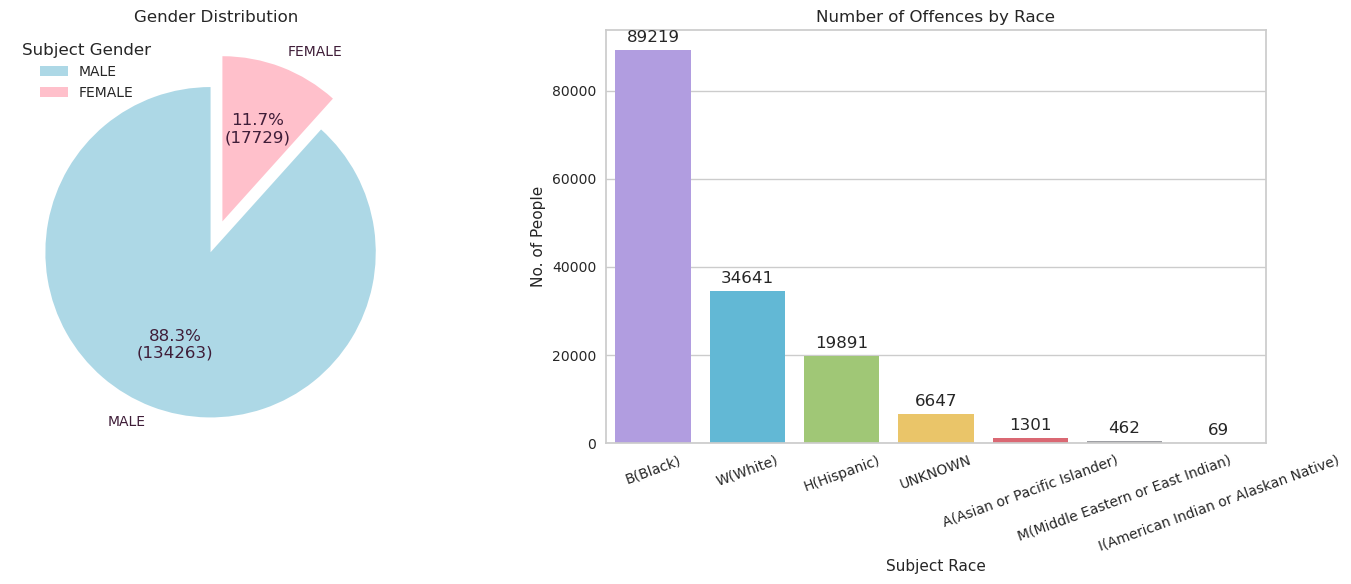

In [15]:
# Pie Chart
data = [len(df[df['SUBJECT_GENDER'] == feature]) for feature in df['SUBJECT_GENDER'].value_counts().index[0:2]]
labels = ['MALE', 'FEMALE']
colors = ['lightblue', 'pink']
explode = (0.1, 0.1)

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.pie(data, labels=labels, explode=explode, colors=colors, 
        autopct=lambda pct: func(pct, data), startangle=90, textprops=dict(color ="#3F1D38"))
plt.legend(labels, title="Subject Gender")
plt.title("Gender Distribution")

# Bar Chart
plt.subplot(1, 2, 2)
order = df['SUBJECT_RACE'].value_counts().index
colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564', '#9E9FA5']

ax = sns.countplot(x='SUBJECT_RACE', data=df, order=order, palette=colors)  # Pass 'x' and 'data' parameters
for label in ax.containers[0]:
    ax.annotate(format(int(label.get_height())), 
                (label.get_x() + label.get_width() / 2., label.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.xticks(rotation=20)
plt.title('Number of Offences by Race')
plt.xlabel('Subject Race')
plt.ylabel('No. of People')

# Show plots
plt.tight_layout()
plt.show()

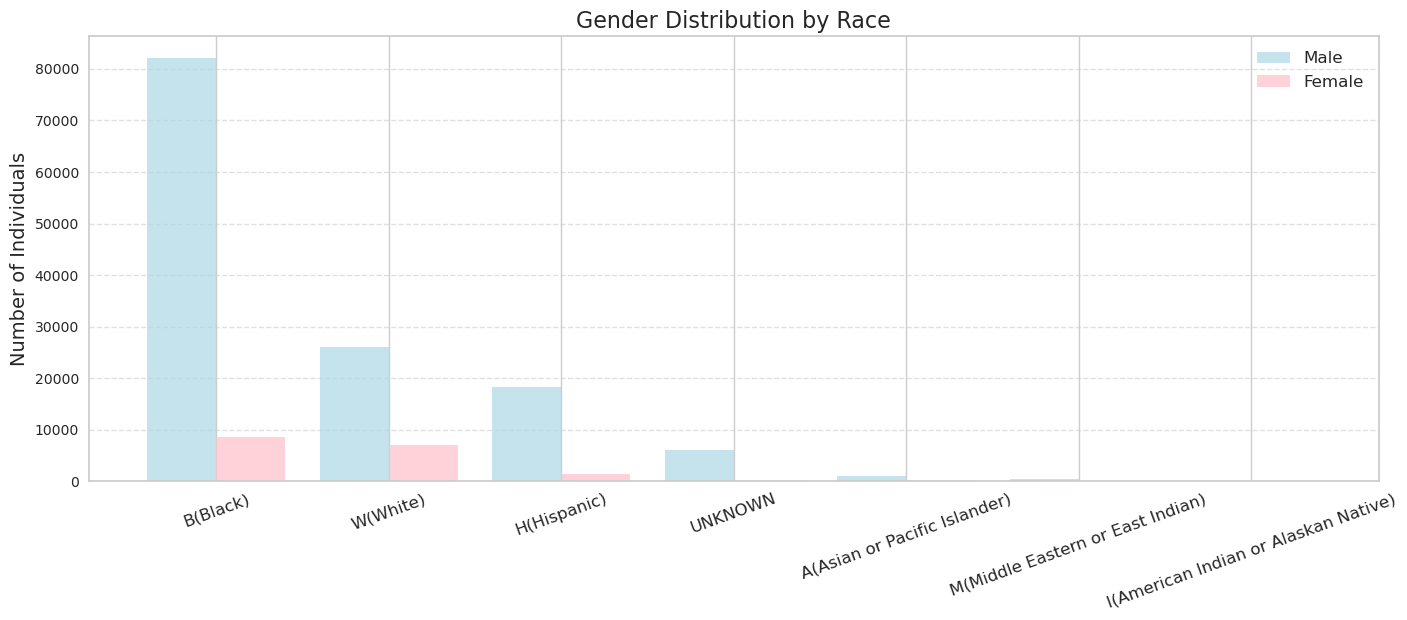

In [16]:
# Set the figure size
plt.figure(figsize=(15, 7))

# Extract unique race categories to plot
race_to_plot = df['SUBJECT_RACE'].value_counts().keys()

# Filter data for male and female subjects
male = df[df['SUBJECT_GENDER'] == 'MALE']
female = df[df['SUBJECT_GENDER'] == 'FEMALE']

# Count the occurrences of gender and race combinations for male and female
values = [male['SUBJECT_RACE'].value_counts(), 
          female['SUBJECT_RACE'].value_counts()]

# Set up positions for the bars
x = np.arange(len(race_to_plot))
width = 0.4  # Width of the bars
colors = ['lightblue', 'pink']  # Colors for male and female bars

# Create the bar plots with stylish colors
plt.bar(x - width/2, values[0], width, color=colors[0], label='Male', alpha=0.7)
plt.bar(x + width/2, values[1], width, color=colors[1], label='Female', alpha=0.7)

# Set the x-axis labels and tick rotation with a touch of elegance
plt.xticks(x, race_to_plot, rotation=20, fontsize=12)

# Set labels, legend, and a more inviting title
plt.ylabel("Number of Individuals", fontsize=14)
plt.legend(fontsize=12)
plt.title("Gender Distribution by Race", fontsize=16)

# Display the plot with improved layout
plt.tight_layout(pad=3)

# Add a decorative touch
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.show()

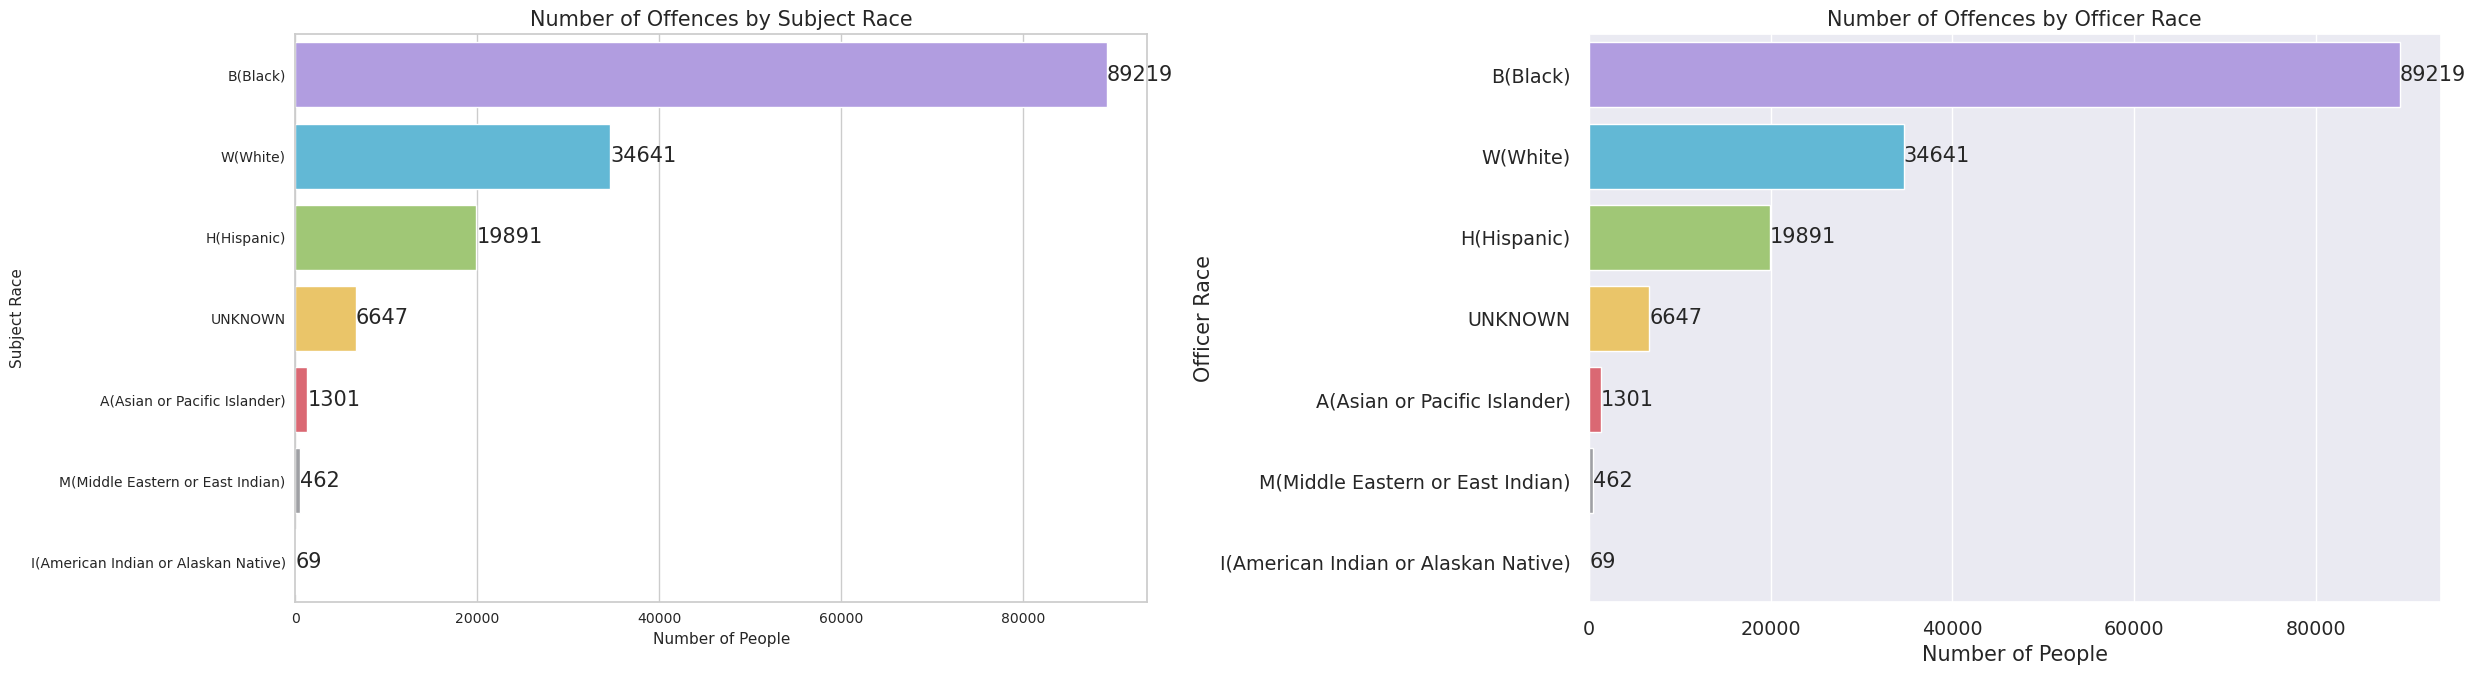

In [17]:
colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564', '#9E9FA5']
plt.figure(figsize=(25, 7))

# Bar Chart - Subject Race
plt.subplot(1, 2, 1)
order_subject = df['SUBJECT_RACE'].value_counts().index

sns.set(font_scale=1.25)
ax = sns.countplot(data=df, y='SUBJECT_RACE', order=order_subject, palette=colors)
for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of Offences by Subject Race')
plt.ylabel('Subject Race')
plt.xlabel('Number of People')


# Bar Chart - Officer Race
sns.set(font_scale=1.25)
plt.subplot(1, 2, 2)
order_officer = df['OFFICER_RACE'].value_counts().index

ax = sns.countplot(data=df, y='OFFICER_RACE', order=order_officer, palette=colors)
for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of Offences by Officer Race')
plt.ylabel('Officer Race')
plt.xlabel('Number of People')

# Show plots
plt.tight_layout() 
plt.show()

### Number of offences distrubuted by Year and Months

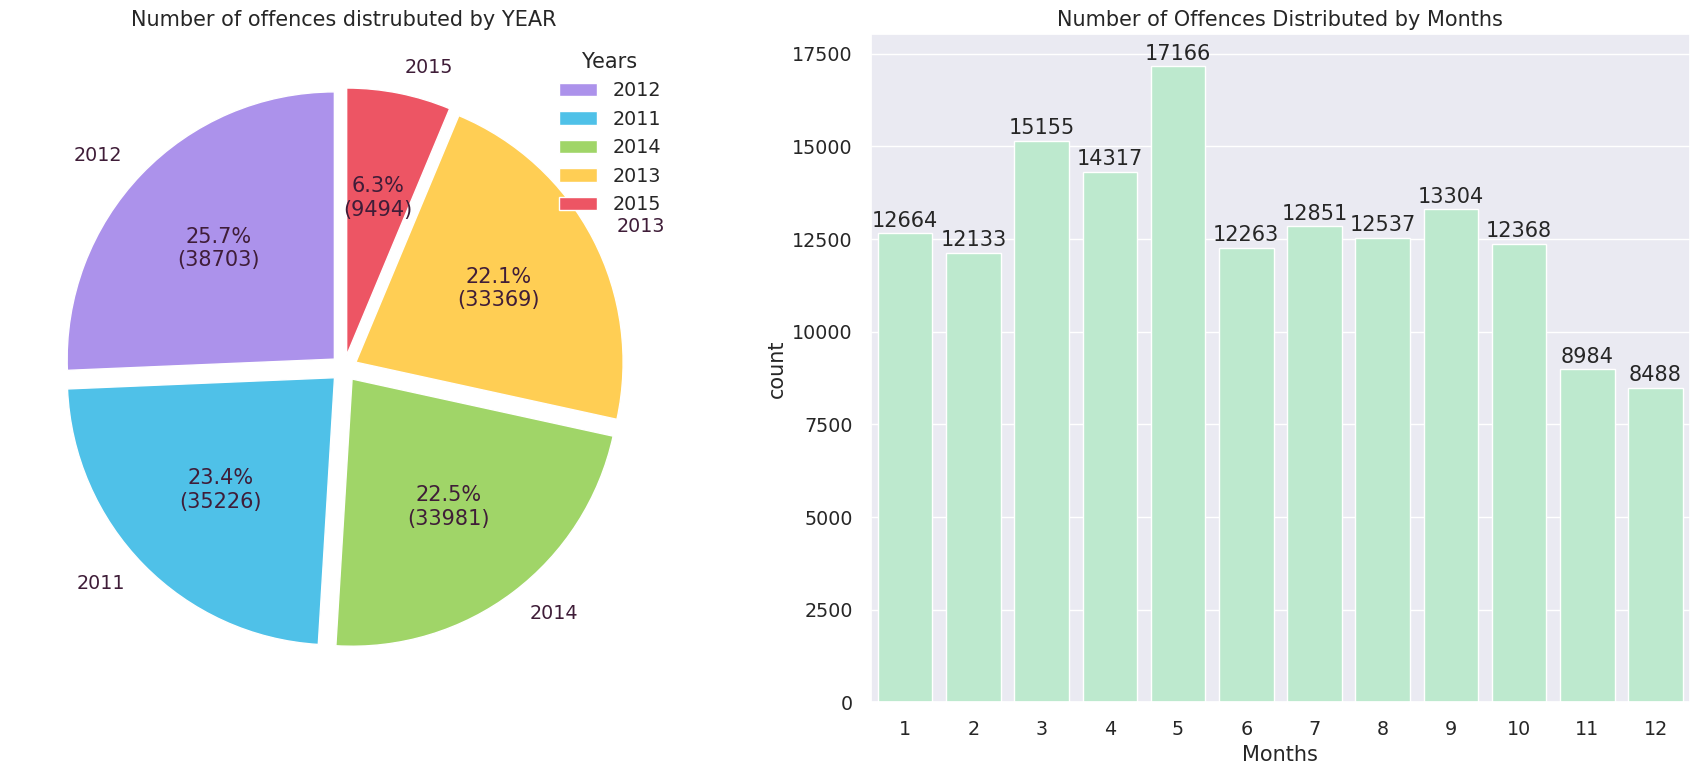

In [18]:
# Pie Chart

# Creating data
data = [len(df[df['INCIDENT_YEAR'] == feature]) for feature in df['INCIDENT_YEAR'].value_counts().index[0:5]]
labels = df['INCIDENT_YEAR'].value_counts().index[0:5]

colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564'] # creating color parameters
explode = (0.05, 0.05, 0.05, 0.05, 0.05) # creating explode data

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating plot
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.pie(data, labels=labels, explode=explode, colors=colors, 
                                  autopct=lambda pct: func(pct, data), startangle=90, textprops=dict(color ="#3F1D38"))

# Adding legend
plt.legend(labels, title ="Years", loc ='best',)

plt.title("Number of offences distrubuted by YEAR")

# Bat chart
color=['#B5F1CC']
plt.subplot(1, 2, 2)
order = df['INCIDENT_MONTH'].value_counts().sort_index().index
ax = sns.countplot(x='INCIDENT_MONTH', data=df, order=order, palette=color)
for label in ax.containers[0]:
    ax.annotate(format(int(label.get_height())), 
                (label.get_x() + label.get_width() / 2., label.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    
plt.title('Number of Offences Distributed by Months')
plt.xlabel('Months')

plt.tight_layout() 
plt.show()

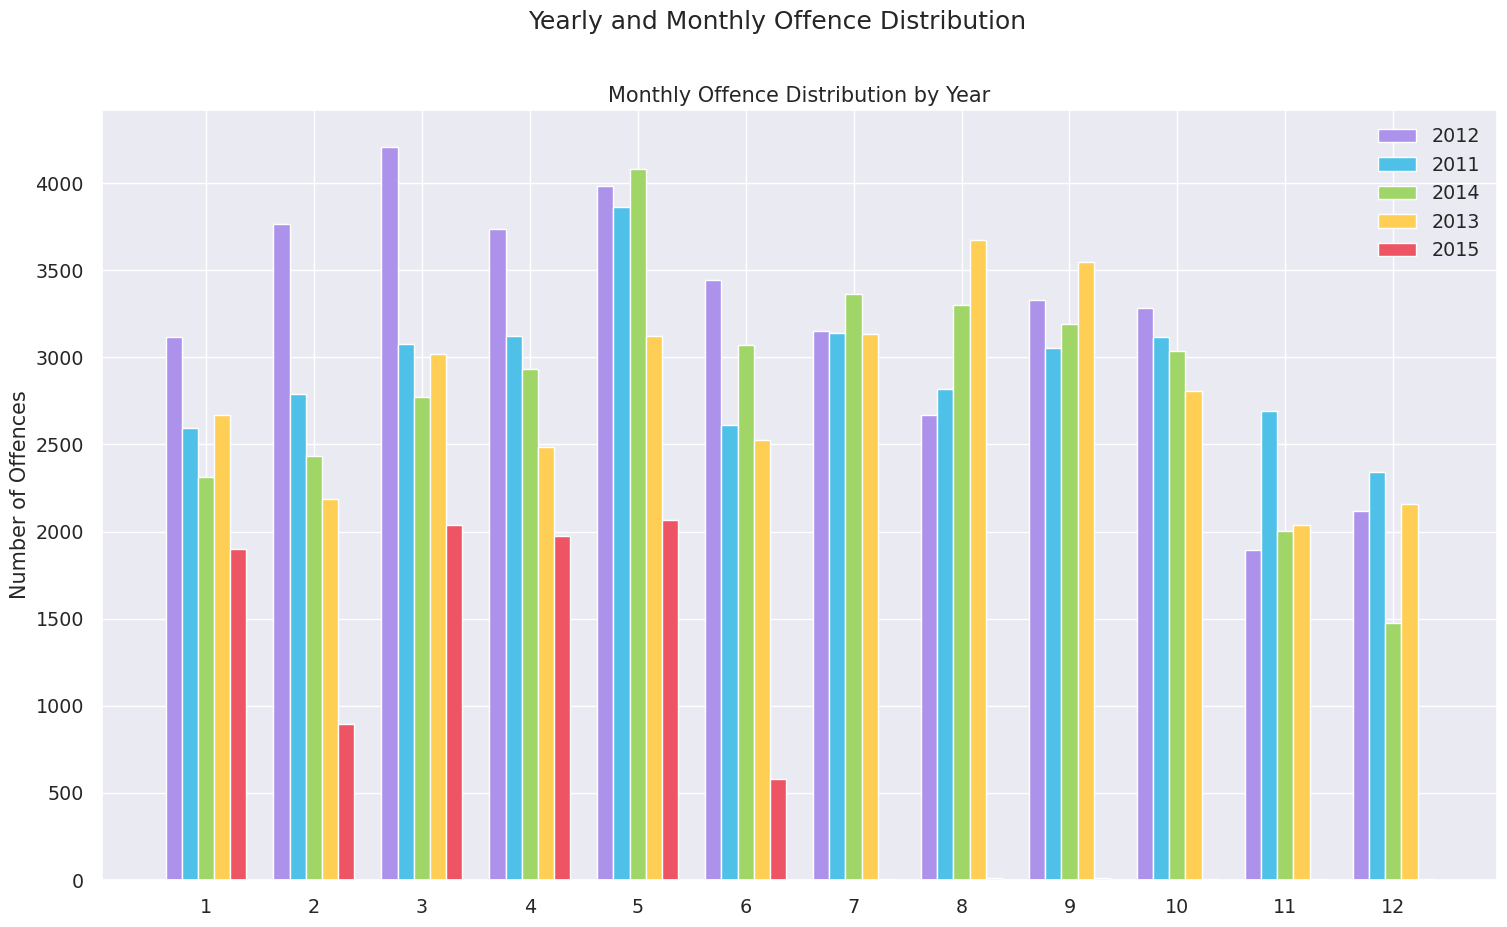

In [19]:
years_to_plot = df['INCIDENT_YEAR'].value_counts().index[:5]
values = []

for year in years_to_plot:
    c = df[df['INCIDENT_YEAR'] == year]
    value = c['INCIDENT_MONTH'].value_counts().sort_index()
    values.append(value)

x = np.arange(1, 13)
width = 0.15
colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564']

plt.figure(figsize=(18, 10))
for n in range(5):
    plt.bar(x + (n - 2) * width, values[n], width=width, color=colors[n])

plt.xticks(x, [str(i) for i in range(1, 13)])
plt.ylabel("Number of Offences")
plt.legend(df['INCIDENT_YEAR'].value_counts().index[:5])
plt.title("Monthly Offence Distribution by Year")

# Adding overall title to the entire figure
plt.suptitle("Yearly and Monthly Offence Distribution")

# Show plots
plt.show()

### Number of offences distrubuted by Date and Weekdays

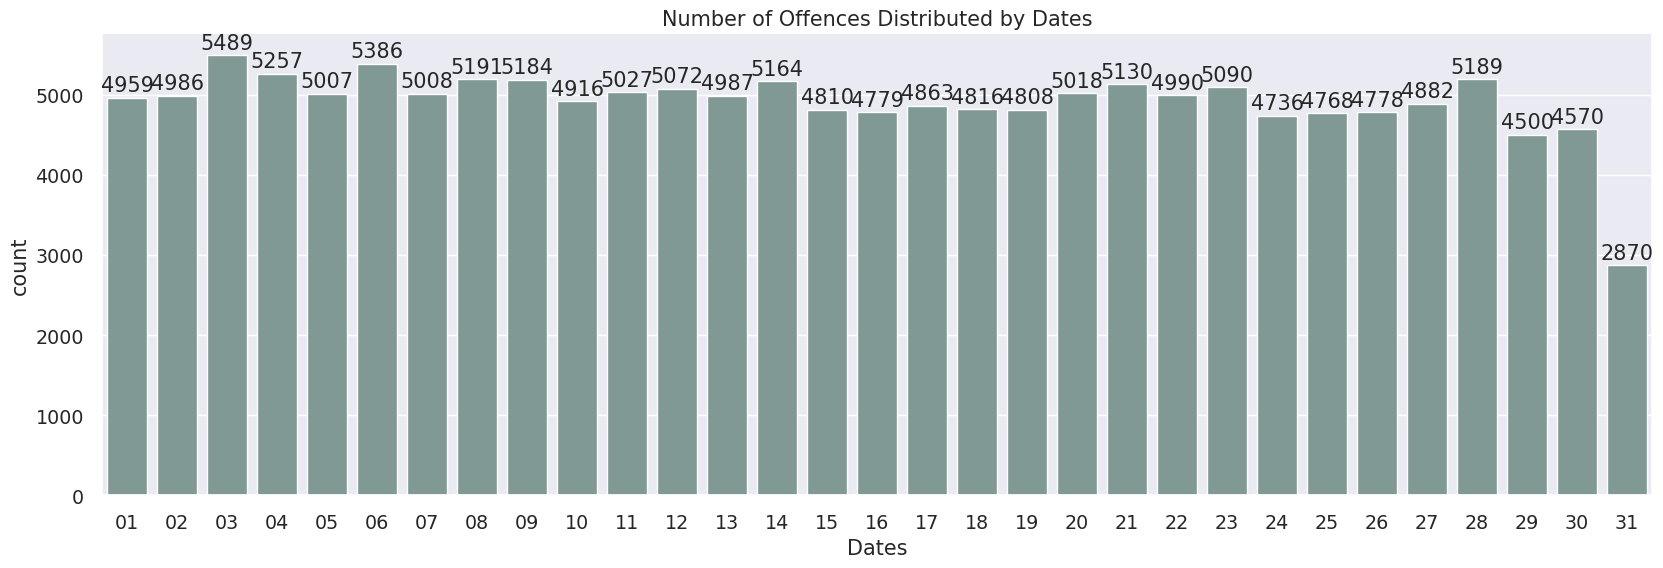

In [20]:
plt.figure(figsize=(20, 6))

# Bar chart for dates
order = df['INCIDENT_DATE'].value_counts().sort_index().index
ax = sns.countplot(x='INCIDENT_DATE',data=df, order=order, color='#7C9D96')

for label in ax.containers[0]:
    ax.annotate(format(int(label.get_height())), 
                (label.get_x() + label.get_width() / 2., label.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.title('Number of Offences Distributed by Dates')
plt.xlabel('Dates')
sns.set(font_scale=1.25)

plt.show()

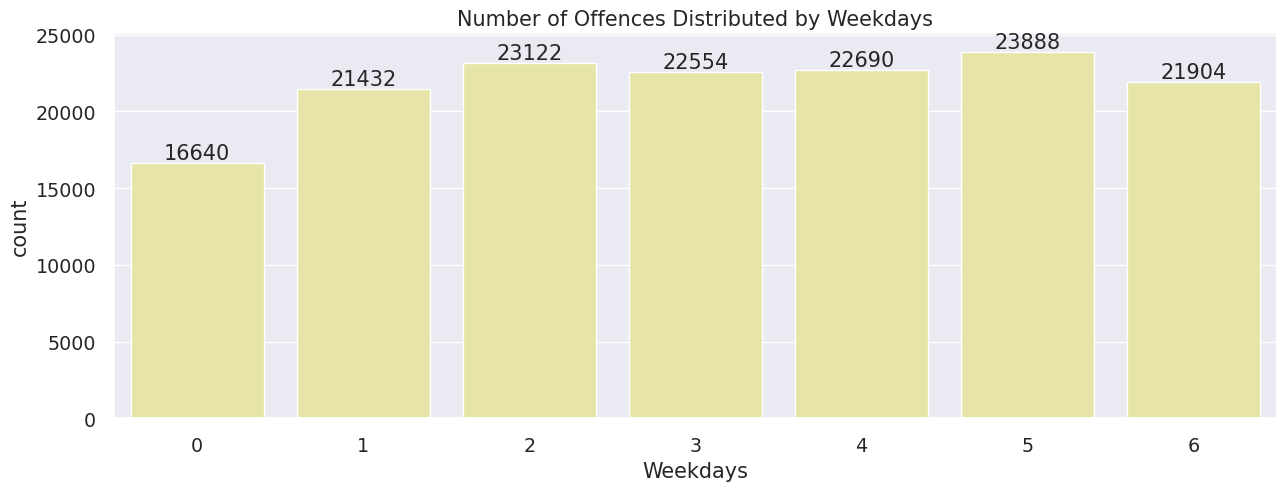

In [21]:
# Bar chart for weekdays
plt.figure(figsize=(15, 5))
order = df['INCIDENT_WEEKDAY'].value_counts().sort_index().index
ax = sns.countplot(x='INCIDENT_WEEKDAY', data=df, order=order, color='#F2EE9D')

for label in ax.containers:
    ax.bar_label(label)
    
plt.title('Number of Offences Distributed by Weekdays')
plt.xlabel('Weekdays')

plt.show()

### Number of offences distrubuted by crimes

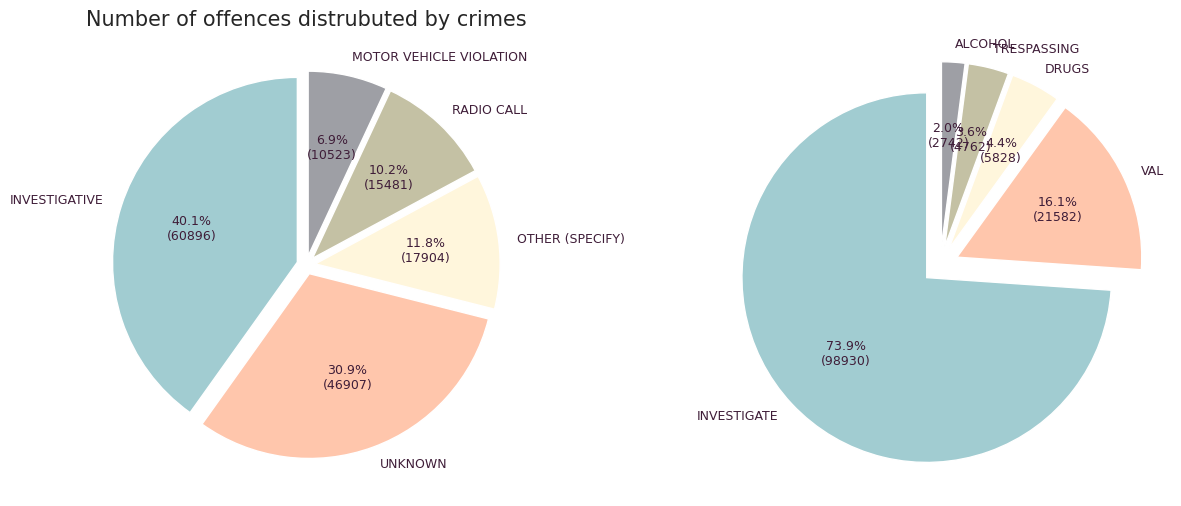

In [22]:
# Creating data
data = [len(df[df['INCIDENT_REASON'] == feature]) for feature in df['INCIDENT_REASON'].value_counts().index[0:5]]
labels = df['INCIDENT_REASON'].value_counts().index[0:5].tolist()

colors = ['#A1CCD1', '#FFC6AC', '#FFF6DC', '#C4C1A4', '#9E9FA5'] # creating color parameters
explode = (0.05, 0.05, 0.05, 0.05, 0.05) # creating explode data

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating plot
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.pie(data, explode=explode, colors=colors, labels=labels,
        autopct=lambda pct: func(pct, data), startangle=90, textprops={'color': "#3F1D38", 'fontsize': 9})
plt.title("Number of offences distrubuted by crimes")

# Adding legend
# plt.legend(labels, title ="Type of crimes",
#           loc ="center left",
#           bbox_to_anchor =(1, 0.1, 0.5, 0.5))


data1 = [len(df[df['INCIDENT_REASON.1'] == feature]) for feature in df['INCIDENT_REASON.1'].value_counts().index[0:5]]
labels1 = df['INCIDENT_REASON.1'].value_counts().index[0:5].tolist()

colors = ['#A1CCD1', '#FFC6AC', '#FFF6DC', '#C4C1A4', '#9E9FA5'] # creating color parameters
explode = (0.1, 0.1, 0.1, 0.1, 0.1) # creating explode data

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating plot
plt.subplot(1, 2, 2)
plt.pie(data1, explode=explode, colors=colors, labels=labels1,
        autopct=lambda pct: func(pct, data1), startangle=90, textprops={'color': "#3F1D38", 'fontsize': 9})

# Adding legend
# plt.legend(labels1, title ="Type of crimes",
#           loc ="center left",
#           bbox_to_anchor =(1, 0.1, 0.5, 0.5))

plt.show()

### Number of offences distrubuted by Officer Age

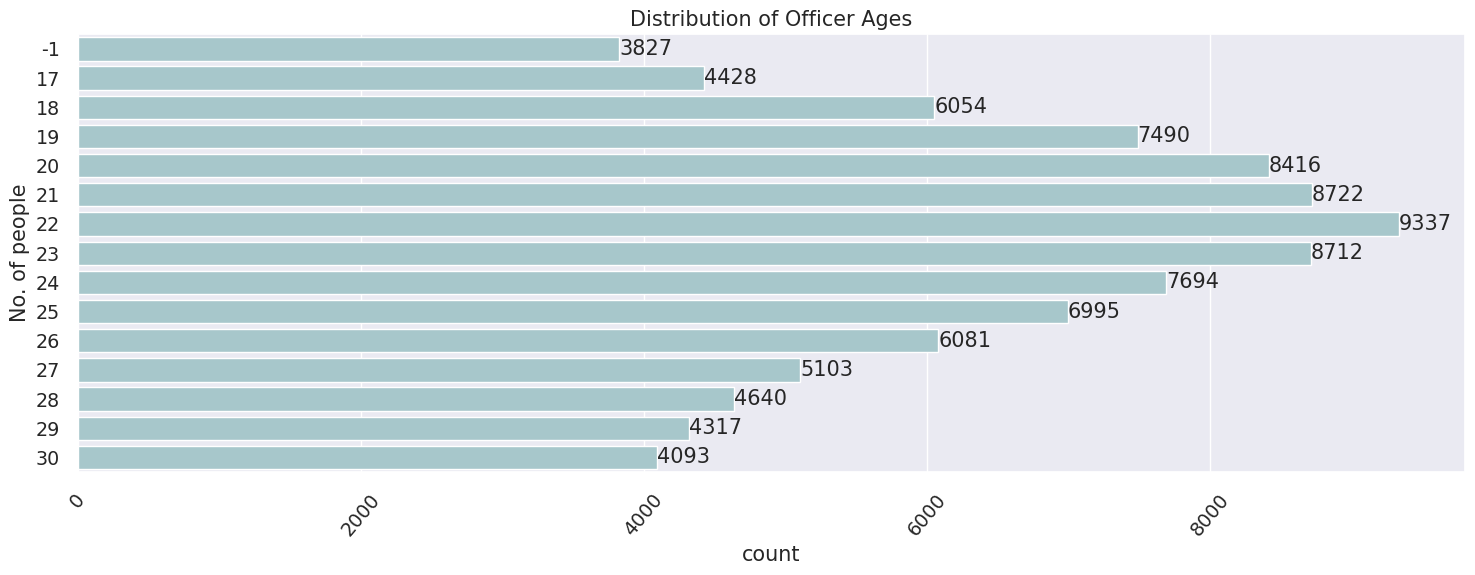

In [23]:
# Bar Chart
order = df['OFFICER_AGE'].value_counts().index[:15].sort_values()
plt.figure(figsize=(15, 6))

ax = sns.countplot(y='OFFICER_AGE', data=df, order=order, color='#A1CCD1')
for label in ax.containers:
    ax.bar_label(label)

plt.xticks(rotation=50)
plt.title('Distribution of Officer Ages')
plt.ylabel('Age')
plt.ylabel('No. of people')

# Show plots
plt.tight_layout() 
plt.show()

### Number of offences distrubuted by location

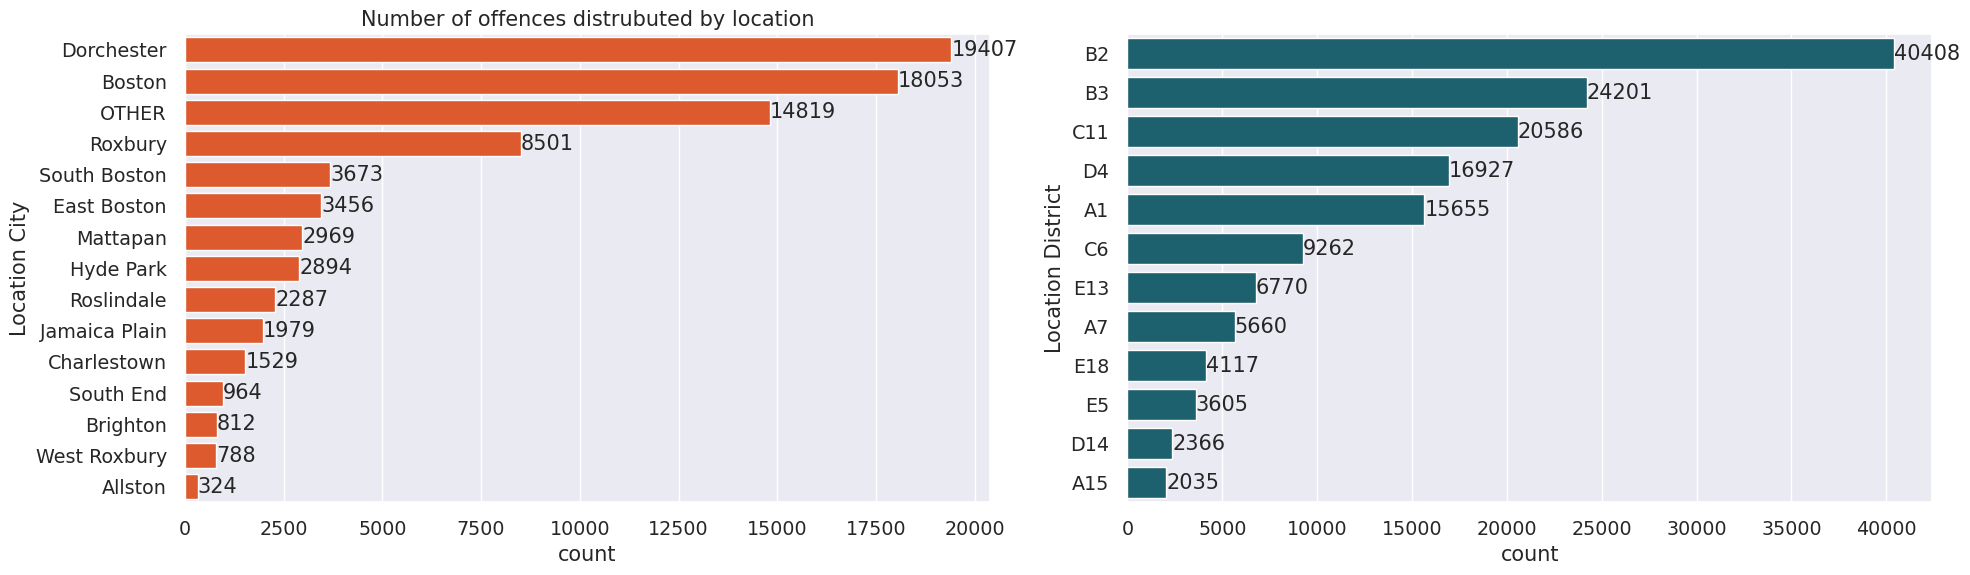

In [24]:
# Bar chart 1: Location city
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
order = df['LOCATION_CITY'].value_counts().index[1:16]
ax = sns.countplot(y=df['LOCATION_CITY'], order=order, color='#F94C10')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of offences distrubuted by location')
plt.ylabel('Location City')

# Bar chart 2: Location district
plt.subplot(1, 2, 2)
order = df['LOCATION_DISTRICT'].value_counts().index[:12]
ax = sns.countplot(y=df['LOCATION_DISTRICT'], order=order, color='#116A7B')

for label in ax.containers:
    ax.bar_label(label)

plt.ylabel('Location District')

plt.tight_layout() 
plt.show()

### Subject Details

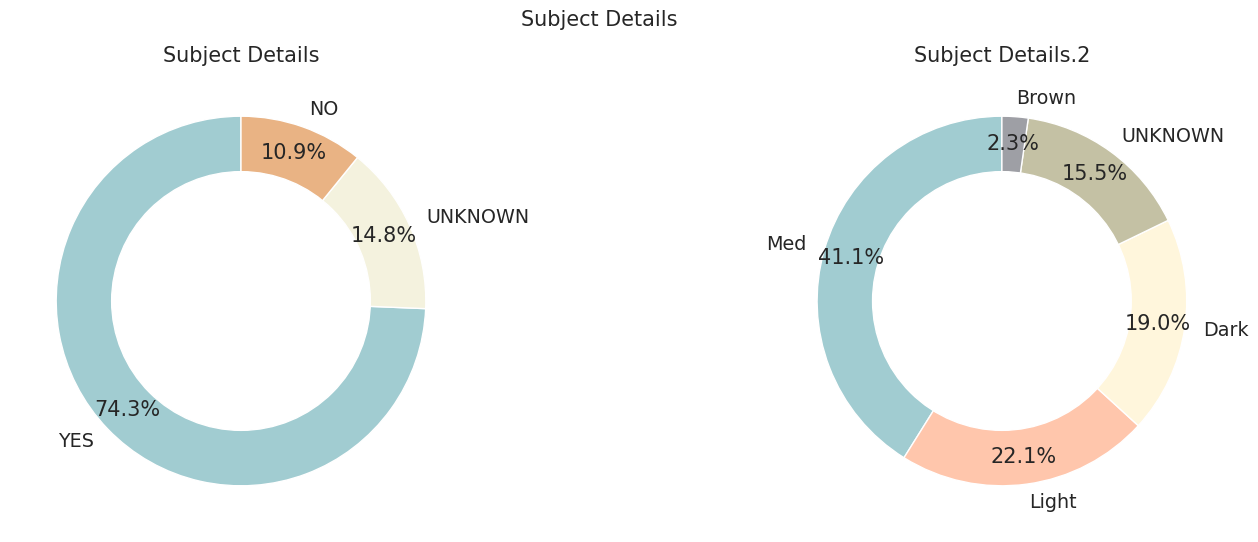

In [25]:
# Creating data
data1 = [len(df[df['SUBJECT_DETAILS'] == feature]) for feature in df['SUBJECT_DETAILS'].value_counts().index]
labels1 = df['SUBJECT_DETAILS'].value_counts().index

# Colors
colors = ['#A1CCD1', '#F4F2DE', '#E9B384'] # creating color parameters
colors1 = ['#A1CCD1', '#FFC6AC', '#FFF6DC', '#C4C1A4', '#9E9FA5'] # creating color parameters

fig, axs = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 3 columns of subplots
plt.suptitle('Subject Details', fontsize=15)

# First Pie: Subject Details
axs[0].pie(data1, colors=colors, labels=labels1, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
centre_circle1 = plt.Circle((0,0),0.70,fc='white')
axs[0].add_artist(centre_circle1)
axs[0].set_title("Subject Details")

# Second Pie Chart: Subject Details.2
data3 = [len(df[df['SUBJECT_DETAILS.2'] == feature]) for feature in df['SUBJECT_DETAILS.2'].value_counts().index[0:5]]
labels3 = df['SUBJECT_DETAILS.2'].value_counts().index[0:5]

axs[1].pie(data3, colors=colors1, labels=labels3, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
centre_circle3 = plt.Circle((0,0),0.70,fc='white')
axs[1].add_artist(centre_circle3)
axs[1].set_title("Subject Details.2")

plt.show()

### Vehicle Details

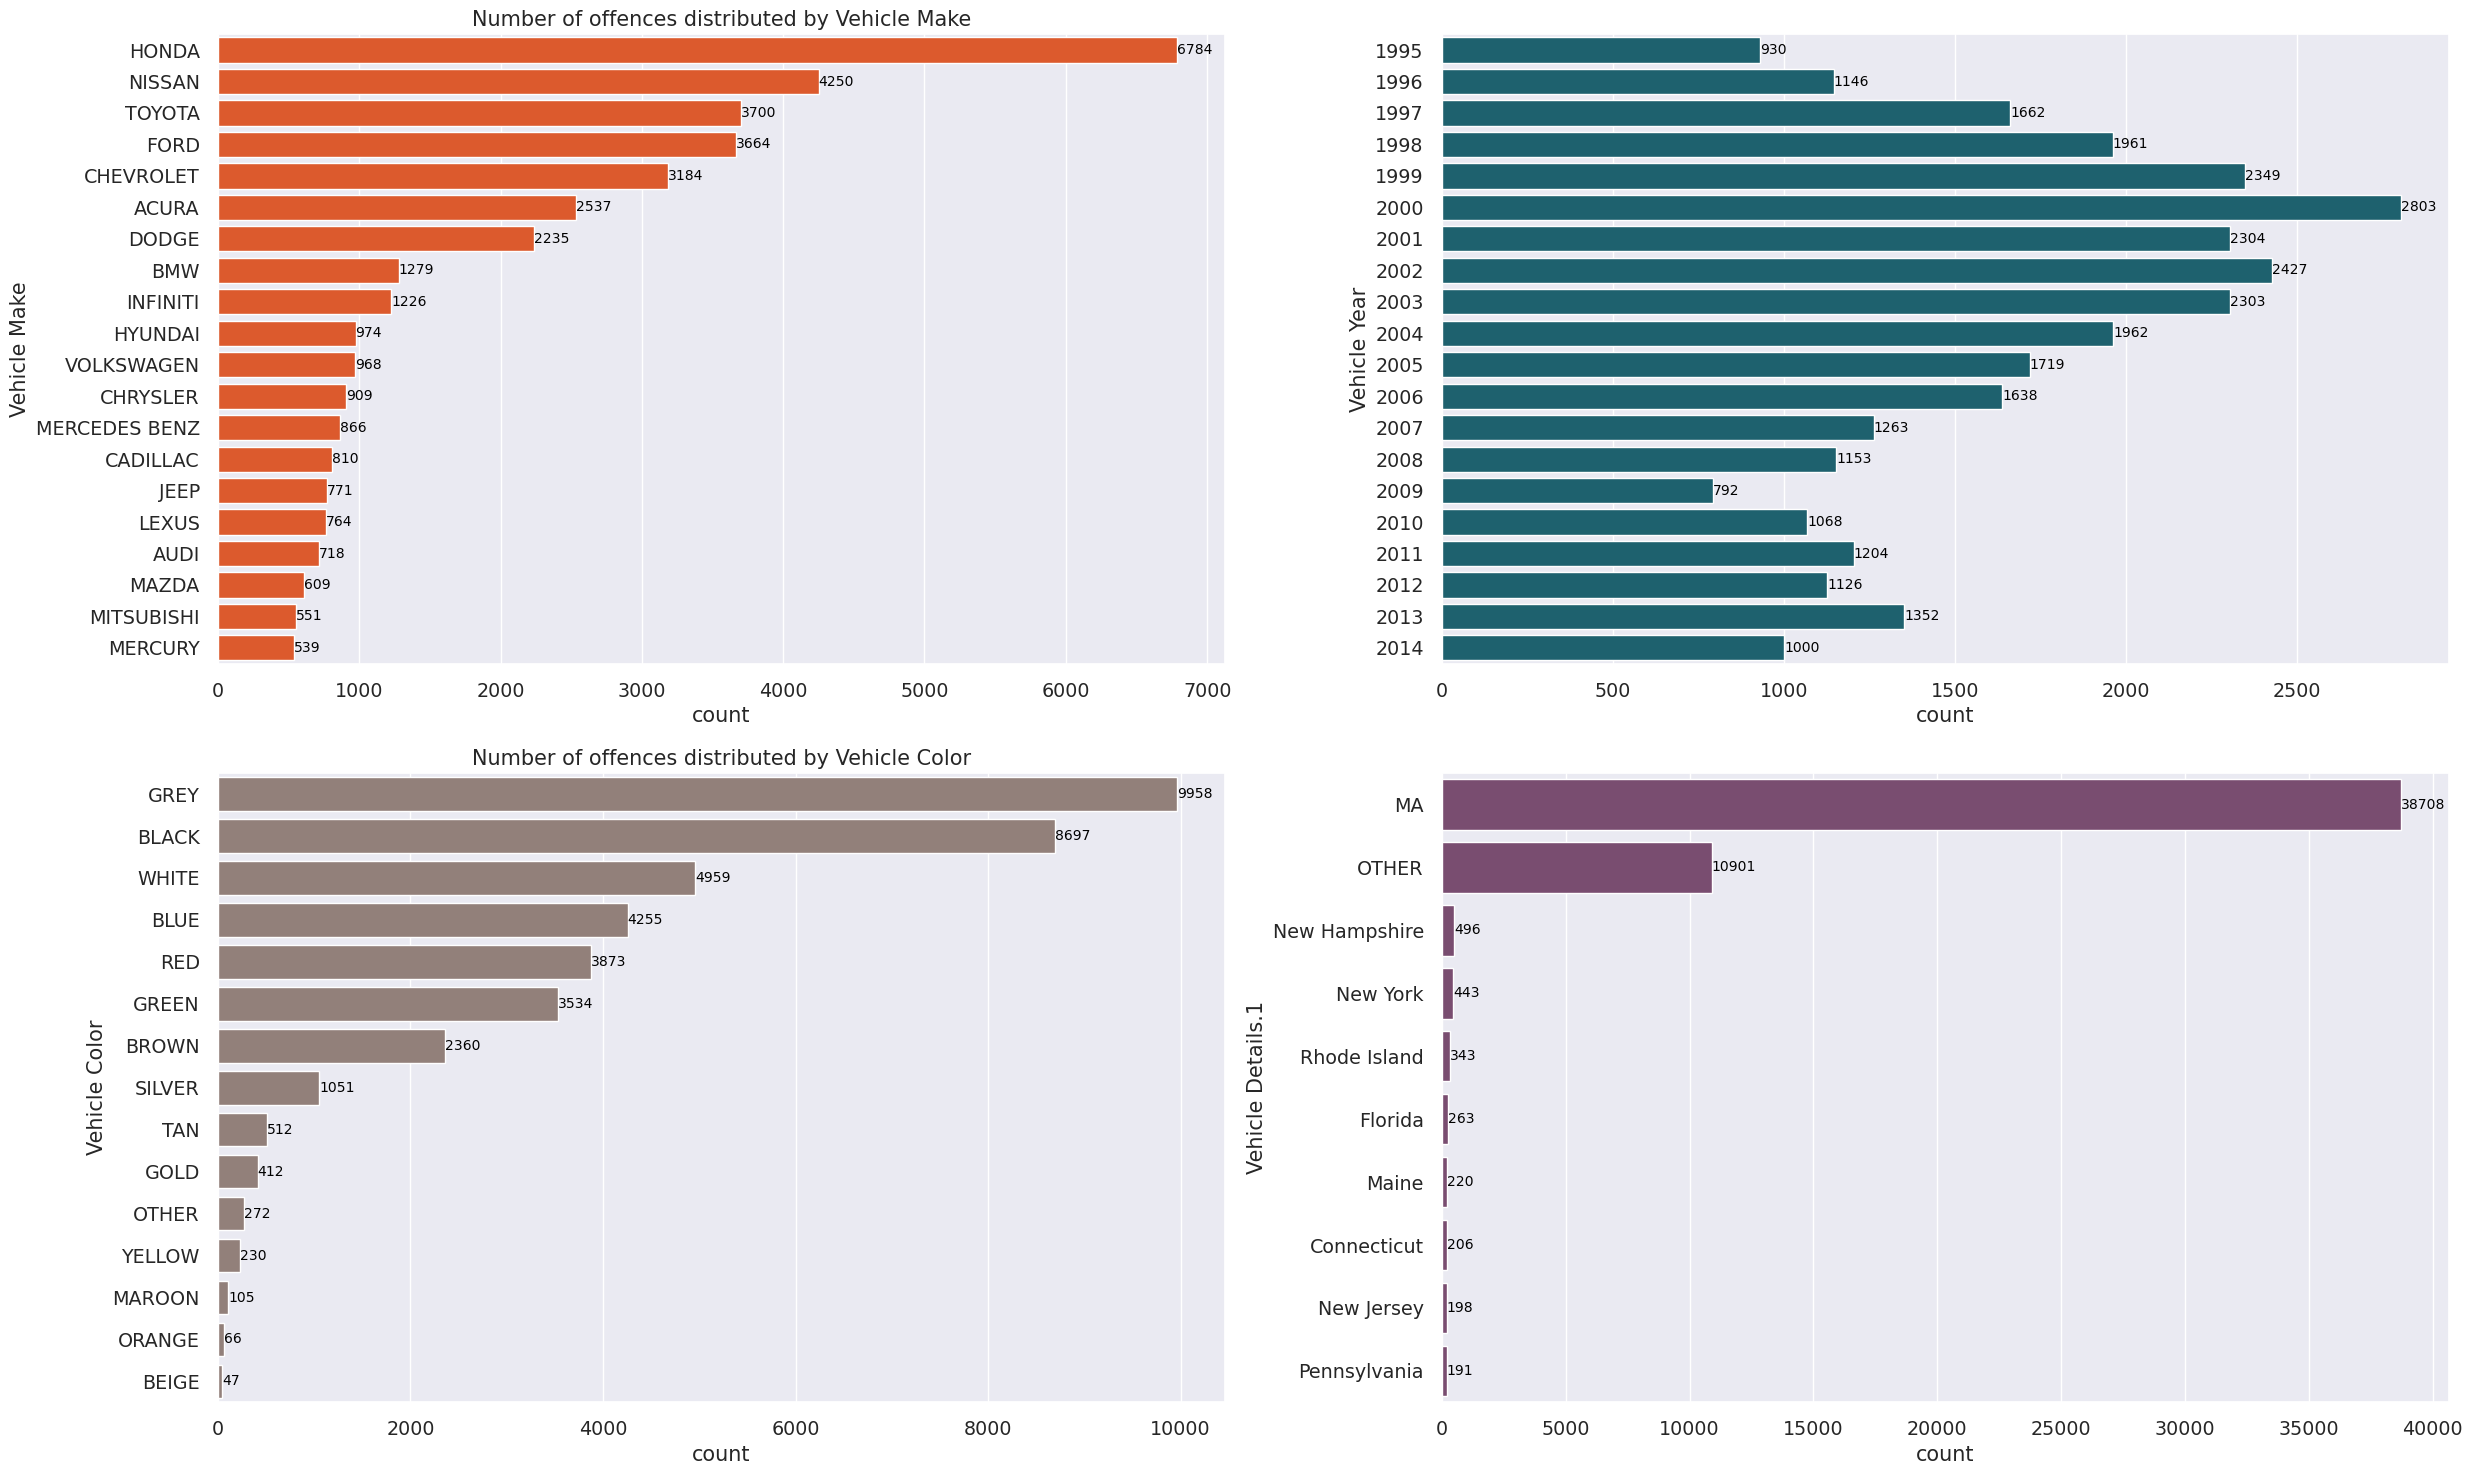

In [26]:
plt.figure(figsize=(25, 15))

# Bar chart 1: Vehicle Make
plt.subplot(2, 2, 1)
order = df["VEHICLE_MAKE"].value_counts().index[1:21]
ax = sns.countplot(y=df['VEHICLE_MAKE'], order=order, color='#F94C10')
for label in ax.containers:
    ax.bar_label(label, label_type='edge', fontsize=10, color='black')  # Adding labels to the bars
plt.title('Number of offences distributed by Vehicle Make')
plt.ylabel('Vehicle Make')

# Bar chart 2: Vehicle Year
plt.subplot(2, 2, 2)
order = df["VEHICLE_YEAR"].value_counts().sort_index().index[27:47]
ax = sns.countplot(y=df['VEHICLE_YEAR'], order=order, color='#116A7B')
for label in ax.containers:
    ax.bar_label(label, label_type='edge', fontsize=10, color='black')  # Adding labels to the bars
plt.ylabel('Vehicle Year')

# Bar chart 3: Vehicle Color
plt.subplot(2, 2, 3)  # Using the correct subplot indices
order = df["VEHICLE_COLOR"].value_counts().index[1:16]
ax = sns.countplot(y=df['VEHICLE_COLOR'], order=order, color='#967E76')
for label in ax.containers:
    ax.bar_label(label, label_type='edge', fontsize=10, color='black')  # Adding labels to the bars
plt.title('Number of offences distributed by Vehicle Color')
plt.ylabel('Vehicle Color')

# Bar chart 4: Vehicle Details.1
plt.subplot(2, 2, 4)  # Using the correct subplot indices
order = df["VEHICLE_DETAILS.1"].value_counts().index[1:11]
ax = sns.countplot(y=df['VEHICLE_DETAILS.1'], order=order, color='#804674')
for label in ax.containers:
    ax.bar_label(label, label_type='edge', fontsize=10, color='black')  # Adding labels to the bars
plt.ylabel('Vehicle Details.1')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [27]:
df['INCIDENT_YEAR'] = df['INCIDENT_YEAR'].astype(int)
replace = df[(df['INCIDENT_YEAR'] < 1990) | (df['INCIDENT_YEAR'] > 2015)]['INCIDENT_YEAR'].tolist()
value = round(df[(df['INCIDENT_YEAR'] >= 1990) | (df['INCIDENT_YEAR'] <= 2015)]['INCIDENT_YEAR'].mean())
df['INCIDENT_YEAR'].replace(to_replace=replace, value=value, inplace=True)

In [28]:
df['INCIDENT_YEAR'].value_counts()

2012    38703
2011    35227
2014    33981
2013    33434
2015     9494
2010      922
2008      207
2007      161
2009       43
2006       19
2003        9
2004        9
1993        5
1994        3
2002        3
1990        3
1991        2
2001        2
1995        1
1992        1
2005        1
Name: INCIDENT_YEAR, dtype: int64

In [29]:
df['VEHICLE_YEAR'].value_counts()

0          117343
2000         2803
2002         2427
1999         2349
2001         2304
2003         2303
2004         1962
1998         1961
2005         1719
1997         1662
2006         1638
2013         1352
2007         1263
2011         1204
2008         1153
1996         1146
2012         1126
2010         1068
2014         1000
1995          930
2009          792
1994          761
1993          549
1992          345
2015          261
1991          225
UNKNOWN       181
1990          146
1989           73
1988           48
1987           29
1986           25
1980           25
1984           13
1985            7
1981            6
1983            5
1982            5
1979            4
2016            3
1975            2
1965            2
1960            1
1978            1
1967            1
1977            1
1955            1
1972            1
2020            1
2017            1
1959            1
1973            1
Name: VEHICLE_YEAR, dtype: int64

In [30]:
# replace weird ages 
df['OFFICER_AGE'] = df['OFFICER_AGE'].astype(int)
replace = df[(df['OFFICER_AGE'] < 18) | (df['OFFICER_AGE'] > 75)]['OFFICER_AGE'].tolist()
value = round(df[(df['OFFICER_AGE'] >= 18) | (df['OFFICER_AGE'] <= 75)]['OFFICER_AGE'].mean())
df['OFFICER_AGE'].replace(to_replace=replace, value=value, inplace=True)

In [31]:
len(df['OFFICER_AGE'].value_counts())

58

In [32]:
for feature in df.columns:
    try:
        df[feature] = df[feature].astype(int)
    except ValueError: pass
    else: pass
    
df.dtypes

SUBJECT_GENDER         object
LOCATION_DISTRICT      object
LOCATION_DISTRICT.1     int64
INCIDENT_DATE           int64
SUBJECT_DETAILS        object
SUBJECT_RACE           object
SUBJECT_DETAILS.2      object
INCIDENT_REASON        object
INCIDENT_REASON.1      object
DISPOSITION            object
VEHICLE_MAKE           object
VEHICLE_YEAR           object
VEHICLE_COLOR          object
VEHICLE_DETAILS.1      object
OFFICER_RACE           object
OFFICER_AGE             int64
LOCATION_CITY          object
INCIDENT_YEAR           int64
INCIDENT_MONTH          int64
INCIDENT_WEEKDAY        int64
dtype: object

In [33]:
df['VEHICLE_YEAR'] = df['VEHICLE_YEAR'].astype(str)
df['INCIDENT_YEAR'] = df['INCIDENT_YEAR'].astype(str)

In [34]:
df.drop(['SUBJECT_RACE', 'OFFICER_RACE'], axis=1, inplace=True)

# Step 3: Feature Engineering

In [35]:
# Label encoding
categorical_features = df.select_dtypes(include=['object', 'category'])

for feature in categorical_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    
df.head()

,SUBJECT_GENDER,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,SUBJECT_DETAILS,SUBJECT_DETAILS.2,INCIDENT_REASON,INCIDENT_REASON.1,DISPOSITION,VEHICLE_MAKE,VEHICLE_YEAR,VEHICLE_COLOR,VEHICLE_DETAILS.1,OFFICER_AGE,LOCATION_CITY,INCIDENT_YEAR,INCIDENT_MONTH,INCIDENT_WEEKDAY
0,1,4,3,10,2,5,2,32,5,32,44,11,18,59,21,18,12,2
1,1,0,1,24,0,5,5,32,0,43,0,13,41,26,16,17,5,4
2,1,8,5,4,2,2,4,54,0,43,0,13,41,18,21,17,6,1
3,1,4,3,21,2,5,2,3,3,43,0,13,41,24,7,19,6,6
4,1,4,3,2,2,4,2,88,0,39,33,10,18,70,7,15,12,4


In [36]:
df.shape

(152230, 18)

In [37]:
numerical_feature = df.select_dtypes(include=['int64'])

for feature in numerical_feature:
    df[feature] = df[feature].astype('uint8')

# Step 4: Dimensionality Reduction

### Principal Component Analysis

In [38]:
scaled_data = StandardScaler().fit_transform(df)
pca = PCA().fit(scaled_data)
pca.explained_variance_

array([3.44202365, 2.00057138, 1.3935684 , 1.14500936, 1.10347287,
       1.02581015, 1.01110273, 0.98698651, 0.94969414, 0.91096592,
       0.83781026, 0.81214793, 0.74059342, 0.70225929, 0.35481233,
       0.27675906, 0.17426042, 0.13227043])

In [39]:
var_exp = pca.explained_variance_ratio_ * 100
print(np.round_(var_exp, decimals = 5))

[19.12223 11.11421  7.742    6.36112  6.13036  5.69891  5.6172   5.48322
  5.27604  5.06089  4.65447  4.5119   4.11438  3.90141  1.97117  1.53754
  0.96811  0.73483]


In [40]:
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)

[ 19.12222801  30.23644044  37.97843623  44.33955758  50.46992212
  56.16882995  61.78603046  67.26925284  72.54529675  77.60618526
  82.26065612  86.77255943  90.88694026  94.78835513  96.75952179
  98.29706204  99.26516911 100.        ]


In [41]:
# extract the Eigenvectors
eig_vecs = pca.components_
eig_vecs

array([[ 1.33703057e-02,  4.03675364e-02,  3.50595249e-02,
        -1.84147020e-03,  2.70388555e-02, -9.90110273e-03,
         8.76571126e-02,  2.65334484e-01, -1.02054901e-01,
        -4.62686936e-01,  4.75728036e-01, -4.54432467e-01,
        -4.94425568e-01, -6.02663832e-02,  1.02703439e-01,
         3.85808689e-02, -2.13813288e-02,  1.18782169e-02],
       [ 7.92472029e-03,  6.45670663e-01,  6.41545356e-01,
         9.38538202e-03,  6.94236009e-02, -8.83332503e-02,
         2.07007913e-01, -6.15366160e-02, -2.89848125e-01,
         6.17254098e-02, -6.74398571e-02,  5.89189289e-02,
         1.47693884e-03, -2.92595323e-02,  7.73689298e-02,
        -8.90369651e-02,  3.73589807e-02, -1.03716149e-02],
       [-2.49078701e-01,  2.11676073e-01,  2.29541132e-01,
        -9.08786273e-03, -2.16375272e-01,  1.26926987e-01,
        -2.83561656e-01, -4.82557843e-02,  3.91218159e-01,
        -5.57360092e-02,  8.49717623e-02, -5.80560406e-02,
        -1.07082001e-01,  3.88734962e-01, -5.71503948e

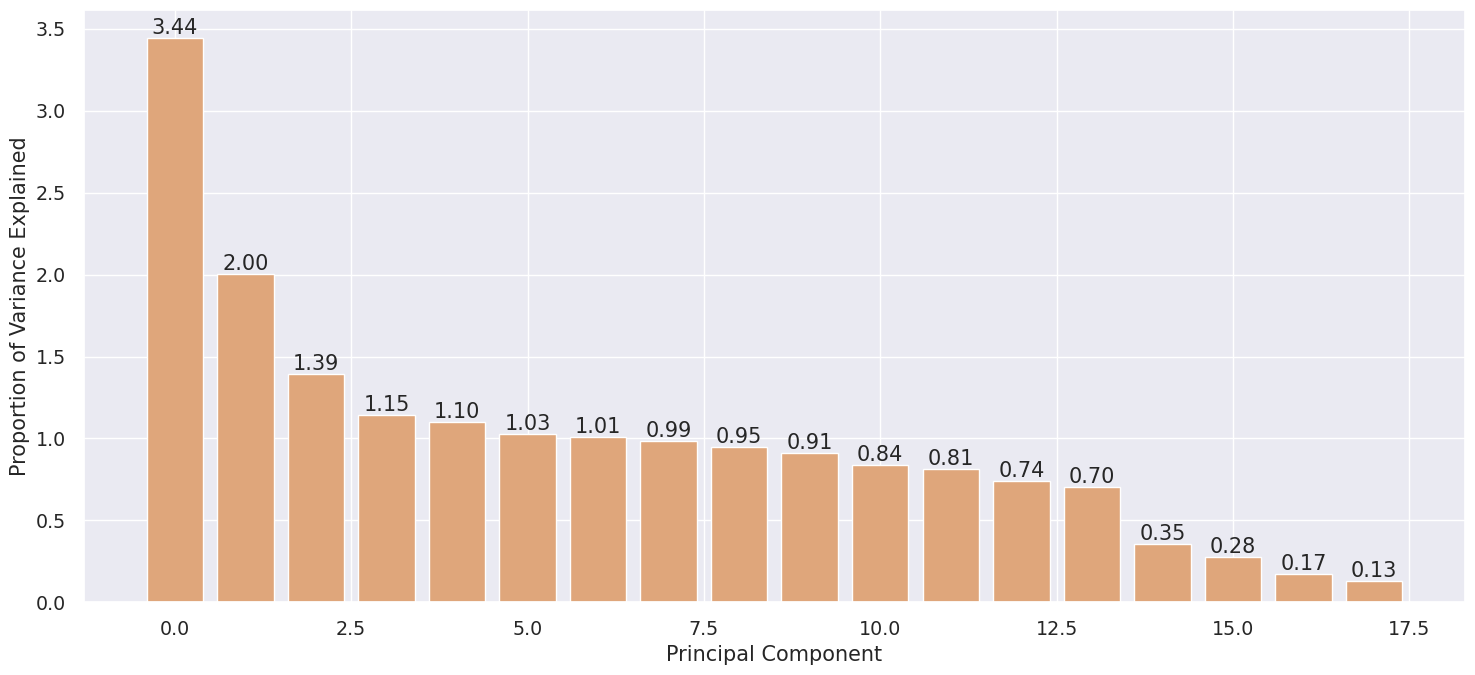

In [42]:
var = pca.explained_variance_ 
labels = list(range(0, len(var)))  # Creating labels for each principal component

plt.figure(figsize=(15, 7))

# Creating the bar plot
ax = plt.bar(labels, var, color="#DFA67B")

# Adding labels on top of each bar
for index, value in enumerate(var):
    plt.text(index, value, f"{value:.2f}", ha='center', va='bottom')

plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')

plt.tight_layout()
plt.show()

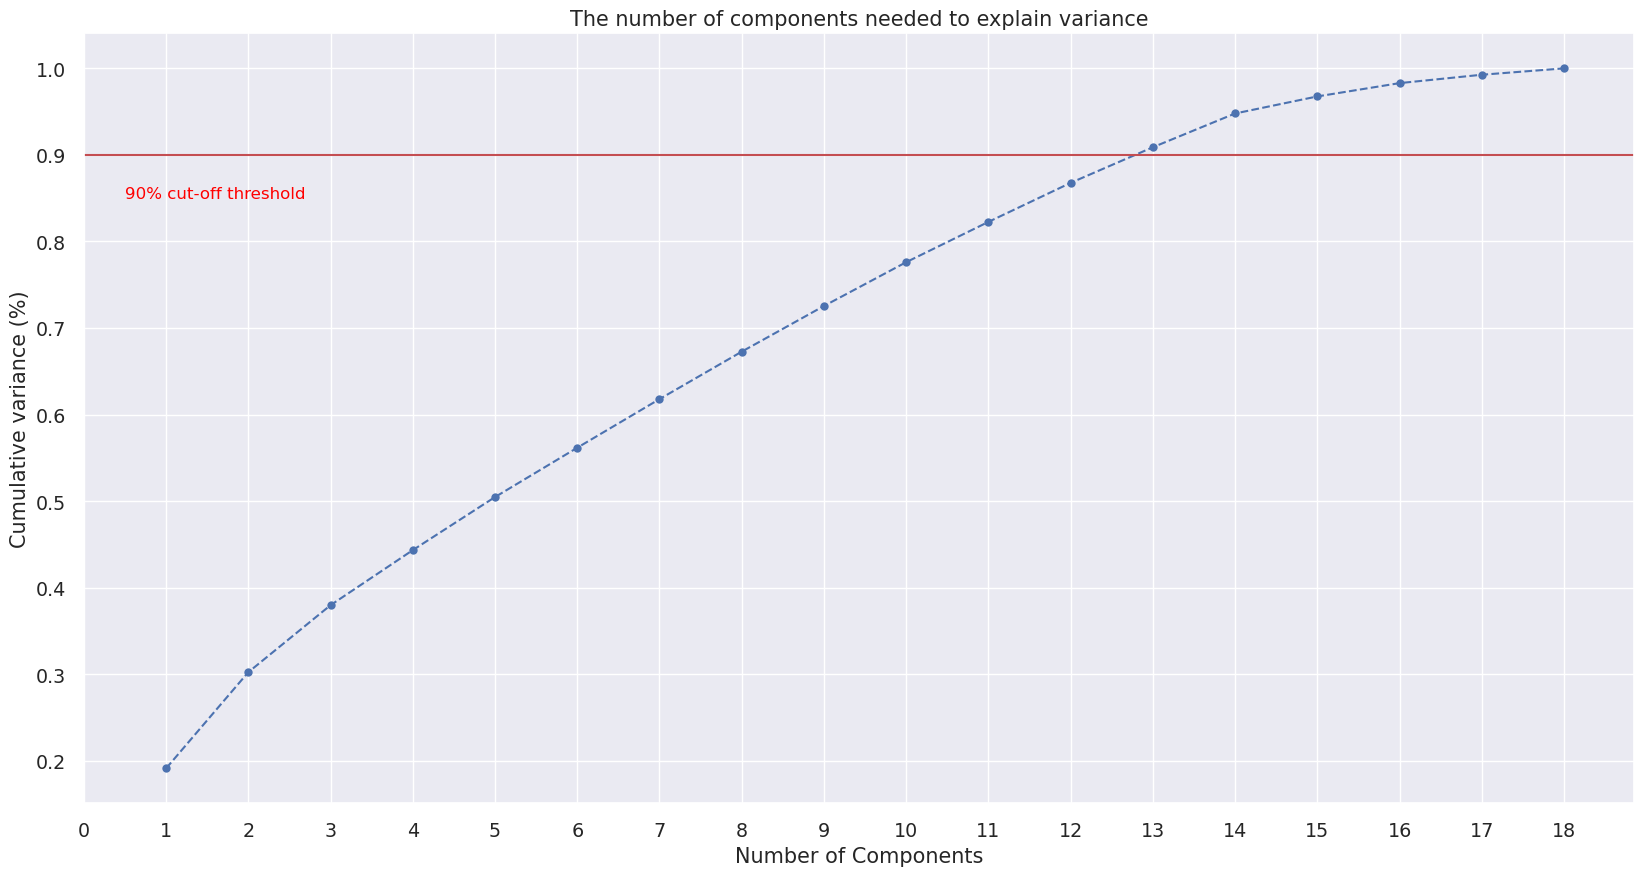

In [43]:
plt.figure(figsize=(20,10))

x = np.arange(1, len(df.columns)+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.plot(x, y, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, len(df.columns)+1, step=1))
plt.ylabel('Cumulative variance (%)')

plt.title('The number of components needed to explain variance')
plt.axhline(y=0.90, color='r', linestyle='-')
plt.text(0.5, 0.85, '90% cut-off threshold', color='red', fontsize=12)

plt.show()

In [44]:
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

In [45]:
# use PCA to project the data 
n_components = 13 # gives 90%
pca = PCA(n_components=n_components)  # Retain 90% of variance
reduced_data = pca.fit_transform(scaled_data)
reduced_data

array([[ 1.25024569, -1.79758062,  1.87121889, ..., -1.50817872,
        -0.10038   ,  0.23163438],
       [-1.46216823, -1.5109574 , -0.86472174, ..., -1.73348522,
         0.72958944,  0.60944395],
       [-0.88181984,  0.73233648, -1.58543002, ...,  0.34800741,
         0.23624361, -0.36308459],
       ...,
       [-0.97860361, -0.75535781, -0.92518704, ..., -0.46560033,
        -0.48030331,  0.45300133],
       [-1.05225123, -1.00501807, -0.28944275, ..., -0.76694572,
        -0.20512675,  1.26626615],
       [-0.75720671,  1.70086996, -0.26216869, ..., -0.09942563,
        -0.76284598, -0.44671682]])

### PCA as Feature Selection

In [46]:
top_components = pca.components_[:n_components]

# Calculate the absolute values of loadings and sort features by importance
feature_importance = np.abs(top_components).sum(axis=0)
sorted_feature_indices = np.argsort(feature_importance)[::-1]

# Select the top features
selected_feature_indices = sorted_feature_indices[:n_components]
selected_features = scaled_df.columns[selected_feature_indices]
selected_features

Index(['INCIDENT_REASON', 'SUBJECT_DETAILS', 'OFFICER_AGE', 'INCIDENT_YEAR',
       'SUBJECT_DETAILS.2', 'INCIDENT_MONTH', 'SUBJECT_GENDER', 'DISPOSITION',
       'INCIDENT_WEEKDAY', 'INCIDENT_DATE', 'INCIDENT_REASON.1',
       'LOCATION_CITY', 'LOCATION_DISTRICT.1'],
      dtype='object')

### Feature Variance

In [47]:
selector_ = VarianceThreshold(threshold=0.5)
selector_.fit_transform(df)
cols_ind = selector_.get_support(indices=True)
cols_names = df.columns
selected_cols_names = [cols_names[i] for i in cols_ind]
len(selected_cols_names)

16

# Step 5: Cluster Analysis

### Choosing the Number of Clusters k

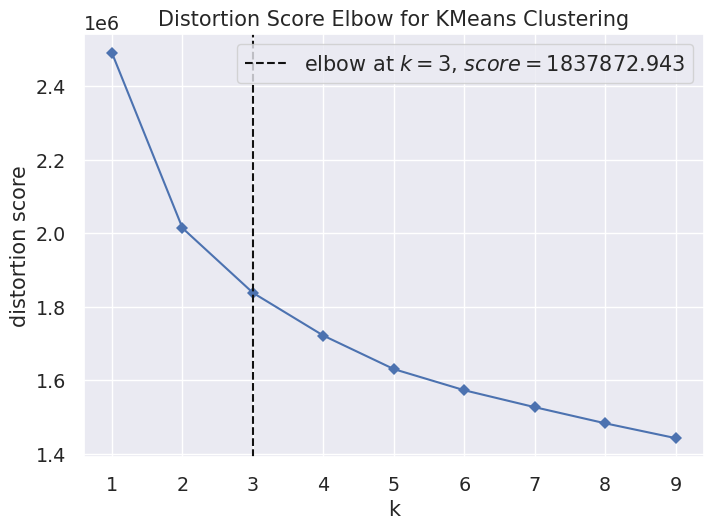

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [48]:
# create a k-Means model an Elbow-Visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 10), timings=False)
 
# fit the visualizer and show the plot
visualizer.fit(reduced_data)
visualizer.show()

### K-Means clustering

In [49]:
# clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(reduced_data)
 
# extract centroids of clusters into a dataframe
centers = kmeans.cluster_centers_
 
# extract cluster labels
cluster_assignments = kmeans.labels_

In [50]:
# creating dataframe for reduced data 
reduced_df = pd.DataFrame(reduced_data, columns=selected_features)
reduced_df['CLUSTER'] = cluster_assignments
reduced_df['CLUSTER'] = reduced_df['CLUSTER'].astype("category")
reduced_df.head()

,INCIDENT_REASON,SUBJECT_DETAILS,OFFICER_AGE,INCIDENT_YEAR,SUBJECT_DETAILS.2,INCIDENT_MONTH,SUBJECT_GENDER,DISPOSITION,INCIDENT_WEEKDAY,INCIDENT_DATE,INCIDENT_REASON.1,LOCATION_CITY,LOCATION_DISTRICT.1,CLUSTER
0,1.250246,-1.797581,1.871219,-1.266797,1.980896,-0.106050,-0.539723,0.818490,-1.294351,-0.179903,-1.508179,-0.100380,0.231634,0
1,-1.462168,-1.510957,-0.864722,1.796624,-0.575994,0.012238,0.911174,-0.367051,0.584925,1.112445,-1.733485,0.729589,0.609444,1
2,-0.881820,0.732336,-1.585430,-0.473587,0.402925,-0.392714,-1.610285,-0.853475,0.861466,-0.300016,0.348007,0.236244,-0.363085,1
3,-2.118980,-1.292274,0.946179,-0.843727,-0.890282,-1.360151,1.156613,0.656005,-0.294873,-0.184048,-1.453763,0.954530,-2.060614,1
4,1.506540,-1.050957,1.629173,-1.280544,4.178615,0.556311,0.016761,1.893620,-0.071039,0.119122,0.810770,0.146942,2.390178,0


### Silhouette Score & Davies-Bouldin Index & Variance Ratio Criterion & Within-Cluster Sum of Squares (WCSS)

In [51]:
# silhouette_avg = silhouette_score(reduced_data, kmeans.labels_)
# print('Silhouette Score', silhouette_avg)

db_index = davies_bouldin_score(reduced_data, kmeans.labels_)
print('Davies-Bouldin Index:', db_index)

ch_score = calinski_harabasz_score(reduced_data, kmeans.labels_)
print('Calinski-Harabasz Index (Variance Ratio Criterion):', ch_score)

wcss = kmeans.inertia_
print('Within-Cluster Sum of Squares (WCSS):', wcss)

Davies-Bouldin Index: 2.2215122024401404
Calinski-Harabasz Index (Variance Ratio Criterion): 27024.912212917934
Within-Cluster Sum of Squares (WCSS): 1837873.191293811


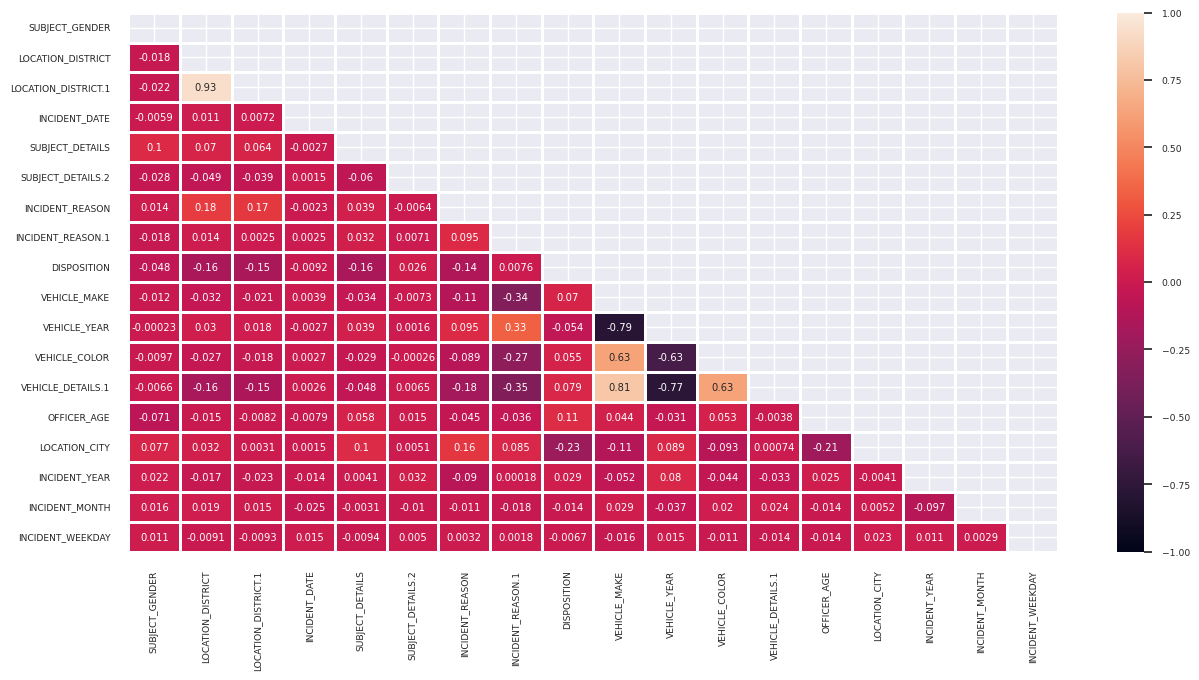

In [52]:
cor_mat = df.corr(method='spearman')

plt.figure(figsize=(15, 7))
sns.set(font_scale=0.6)
mask = np.triu(np.ones_like(cor_mat, dtype=np.bool))
ax = sns.heatmap(cor_mat, annot=True, fmt=".2g", vmin=-1, vmax=1,
                annot_kws={'size': 'medium'}, linewidths=0.8, mask=mask)
plt.show()

In [53]:
reduced_df.head()

,INCIDENT_REASON,SUBJECT_DETAILS,OFFICER_AGE,INCIDENT_YEAR,SUBJECT_DETAILS.2,INCIDENT_MONTH,SUBJECT_GENDER,DISPOSITION,INCIDENT_WEEKDAY,INCIDENT_DATE,INCIDENT_REASON.1,LOCATION_CITY,LOCATION_DISTRICT.1,CLUSTER
0,1.250246,-1.797581,1.871219,-1.266797,1.980896,-0.106050,-0.539723,0.818490,-1.294351,-0.179903,-1.508179,-0.100380,0.231634,0
1,-1.462168,-1.510957,-0.864722,1.796624,-0.575994,0.012238,0.911174,-0.367051,0.584925,1.112445,-1.733485,0.729589,0.609444,1
2,-0.881820,0.732336,-1.585430,-0.473587,0.402925,-0.392714,-1.610285,-0.853475,0.861466,-0.300016,0.348007,0.236244,-0.363085,1
3,-2.118980,-1.292274,0.946179,-0.843727,-0.890282,-1.360151,1.156613,0.656005,-0.294873,-0.184048,-1.453763,0.954530,-2.060614,1
4,1.506540,-1.050957,1.629173,-1.280544,4.178615,0.556311,0.016761,1.893620,-0.071039,0.119122,0.810770,0.146942,2.390178,0


In [54]:
# sns.pairplot(hue="CLUSTER", data=reduced_df)
# plt.show()